In [1]:
%%sh
# Small cleanup for reproducibility
rm -rf /tmp/dds
rm -rf /tmp/*png

This tutorial is an adaptation of the Machine Learning tutorial from Elite Data Science. The original tutorial is here:

https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn

Let us start with a few imports

In [2]:
import sklearn
import pandas as pd
import numpy as np
 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import requests
import io
import json

We now add the import to the `dds` package. By default, the data will be stored in the temporary directory

In [3]:
import dds

The two internal directories (data and internal) are now there

In [4]:
%%sh
ls -la /tmp/dds

totaal 36
drwxrwxr-x  4 tjhunter tjhunter  4096 Nov 22 12:45 .
drwxrwxrwt 23 root     root     20480 Nov 22 12:45 ..
drwxrwxr-x  2 tjhunter tjhunter  4096 Nov 22 12:45 data
drwxrwxr-x  3 tjhunter tjhunter  4096 Nov 22 12:45 internal


Let's start with a familiar problem of accessing data from the internet. This piece of code will download a dataset, but with the additional twist that the dataset will be cached onto the local machine.

In [5]:
path_model = "/wine-quality/my_model"
path_model_stats = "/wine-quality/my_model_stats.json"

@dds.dds_function("/wine-quality/raw")
def data():
    print("*** in _load_data ***")
    url = "https://raw.githubusercontent.com/zygmuntz/wine-quality/master/winequality/winequality-red.csv"
    x = requests.get(url=url, verify=False).content 
    return pd.read_csv(io.StringIO(x.decode('utf8')), sep=";")


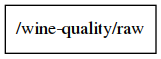

In [6]:
dds.eval(data, dds_export_graph="/tmp/2.png", dds_extra_debug=True, dds_stages=["analysis"])
from IPython.display import Image
Image("/tmp/2.png")

In [7]:
data().head(3)

*** in _load_data ***


/home/tjhunter/work/software/miniconda/envs/dds/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [8]:
def build_model(X_train, y_train):
    print("*** in build_model ***")
    pipeline = make_pipeline(preprocessing.StandardScaler(), 
                             RandomForestRegressor(n_estimators=100))
    hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                      'randomforestregressor__max_depth': [None, 5, 3, 1]}

    clf = GridSearchCV(pipeline, hyperparameters, cv=10)
    
    clf.fit(X_train, y_train)
    return clf
 
    
def model_stats(clf, X_test, y_test) -> str:
    print("*** in model_stats ***")
    pred = clf.predict(X_test)
    return json.dumps({
#         "r2_score": r2_score(y_test, pred),
        "mse": mean_squared_error(y_test, pred)
    })
    
    
def pipeline():
    wine_data = data()
    y = wine_data.quality
    X = wine_data.drop('quality', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.15, 
                                                        random_state=123, 
                                                        stratify=y)
    clf = dds.keep(path_model, build_model, X_train, y_train)
    dds.keep(path_model_stats, model_stats, clf, X_test, y_test)
    print("*** done ***")


# dds.eval(pipeline, dds_export_graph="1.png")


In [9]:
%%sh
# cat /tmp/data/wine-quality/my_model_stats.json

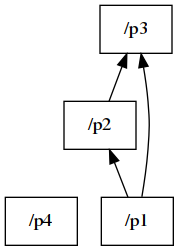

In [10]:

@dds.dds_function("/p1")
def f1(): return 2 

@dds.dds_function("/p2")
def f2(): return 2 + f1()

@dds.dds_function("/p3")
def f3(): return 1 + f1() + f2()

@dds.dds_function("/p4")
def f4(): return 1


def f():
    f4()
    f3()

dds.eval(f, dds_export_graph="/tmp/2.png", dds_extra_debug=True, dds_stages=["analysis"])
from IPython.display import Image
Image("/tmp/2.png")

In [11]:
f()